In [15]:
import tensorflow as tf

# 查看 GPU 数量
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# 查看 GPU 详细信息
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # 设置 GPU 内存自增长（按需分配）
  for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    print("GPU 名称:", gpu.name)

Num GPUs Available:  1
GPU 名称: /physical_device:GPU:0


In [16]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # 若你的NVIDIA显卡是第0块，设为"0"
import tensorflow as tf

# 验证GPU
gpus = tf.config.list_physical_devices('GPU')
print("可用GPU数量：", len(gpus))
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU名称：", gpu.name)

可用GPU数量： 1
GPU名称： /physical_device:GPU:0


In [17]:
import tensorflow as tf

# 查看可用的物理设备（包括GPU）
physical_devices = tf.config.list_physical_devices()
print("可用的物理设备：", physical_devices)

# 专门查看GPU设备
gpus = tf.config.list_physical_devices('GPU')
print("可用的GPU数量：", len(gpus))

if gpus:
    # 设置GPU内存自增长（按需分配，避免显存被占满）
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU名称：", gpu.name)

    # 执行一个简单的计算任务，强制触发设备分配
    with tf.device('/GPU:0'):
        a = tf.constant([1.0, 2.0, 3.0], shape=[3], name='a')
        b = tf.constant([1.0, 2.0, 3.0], shape=[3], name='b')
        c = tf.add(a, b)
        print("计算结果：", c.numpy())

        # 查看操作的设备分配信息
        tf.debugging.set_log_device_placement(True)
        print("操作的设备分配日志：")
        print(c)
else:
    print("未检测到可用的NVIDIA GPU，TensorFlow将使用CPU进行计算。")

可用的物理设备： [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
可用的GPU数量： 1
GPU名称： /physical_device:GPU:0
计算结果： [2. 4. 6.]
操作的设备分配日志：
tf.Tensor([2. 4. 6.], shape=(3,), dtype=float32)


In [18]:
import tensorflow as tf
from tensorflow.python.client import device_lib

# 查看 TensorFlow 识别的所有设备
local_devices = device_lib.list_local_devices()
gpu_devices = [device for device in local_devices if device.device_type == 'GPU']

print("TensorFlow 识别的 GPU 设备：")
for i, gpu in enumerate(gpu_devices):
    print(f"TensorFlow 设备编号：/device:GPU:{i}")
    print(f"设备描述：{gpu.physical_device_desc}")

TensorFlow 识别的 GPU 设备：
TensorFlow 设备编号：/device:GPU:0
设备描述：device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


# 一、导入库

In [3]:
import pandas as pd
import numpy as np
import re
import pickle
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Concatenate, Dropout, Bidirectional
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import pandas as pd
import json

In [5]:
from itertools import groupby

# 二、数据准备

In [6]:

def load_json_dataset():
    # 读取合法URL的JSON文件
    legit_path = "data/data_legitimate_36400.json"
    with open(legit_path, "r", encoding="utf-8") as f:
        legit_data = json.load(f)
    # 将索引0重命名为url
    legit_df = pd.DataFrame(legit_data).rename(columns={0: "url"})
    legit_df["is_phishing"] = 0  # 合法URL标签为0

    # 读取钓鱼URL的JSON文件
    phish_path = "data/data_phishing_37175.json"
    with open(phish_path, "r", encoding="utf-8") as f:
        phish_data = json.load(f)
    # 将索引0重命名为url
    phish_df = pd.DataFrame(phish_data).rename(columns={0: "url"})
    phish_df["is_phishing"] = 1  # 钓鱼URL标签为1

    # 合并数据集并去重
    df = pd.concat([legit_df, phish_df], ignore_index=True)
    df = df.drop_duplicates(subset=["url"])
    # 过滤URL长度（5~200字符）
    df = df[df["url"].str.len().between(5, 200)]
    
    return df

# 加载数据集
df = load_json_dataset()
print(f"数据集规模：{len(df)}条URL，钓鱼URL占比：{df['is_phishing'].mean():.2%}")
print(df.head())  # 查看前5行数据确认结构

数据集规模：53130条URL，钓鱼URL占比：43.75%
                                                 url  is_phishing
0  http://www.conceptdraw.com/How-To-Guide/Local-...            0
1   https://www.edrawsoft.com/Local-Area-Network.php            0
2  http://www.webopedia.com/TERM/L/local_area_net...            0
3      https://www.acsac.org/secshelf/book001/16.pdf            0
4        http://www.diffen.com/difference/LAN_vs_WAN            0



# 三、特征提取（手动NLP特征）

In [ ]:

def extract_manual_nlp_features(url):
    features = {}
    # 处理空值和非字符串类型的URL
    if not url or not isinstance(url, str):
        # 空URL返回全0特征
        features["subdomain_count"] = 0
        features["is_known_tld"] = 0
        features["has_punycode"] = 0
        features["domain_length"] = 0
        features["has_ip_address"] = 0
        features["has_at_symbol"] = 0
        features["has_double_slash"] = 0
        features["tld_in_path"] = 0
        features["domain_contains_hyphen"] = 0
        features["domain_contains_digit"] = 0
        features["word_count"] = 0
        features["avg_word_length"] = 0
        features["max_word_length"] = 0
        features["min_word_length"] = 0
        features["digit_count"] = 0
        features["special_char_count"] = 0
        features["uppercase_count"] = 0
        features["lowercase_count"] = 0
        features["consecutive_char_repeat"] = 0
        features["url_length"] = 0
        features["has_brand"] = 0
        features["has_phish_keywords"] = 0
        features["brand_in_domain"] = 0
        features["phish_keyword_in_path"] = 0
        features["long_path"] = 0
        features["has_query_parameters"] = 0
        features["query_parameter_count"] = 0
        features["suspicious_query_words"] = 0
        features["similar_brand_count"] = 0
        features["has_year_in_url"] = 0
        features["has_https"] = 0
        features["has_www"] = 0
        features["domain_www_count"] = 0
        features["path_depth"] = 0
        features["has_anchor"] = 0
        features["anchor_length"] = 0
        features["has_javascript"] = 0
        features["has_iframe"] = 0
        features["has_css"] = 0
        features["has_image"] = 0
        return features
    
    # 正常URL处理逻辑
    parsed = urlparse(url)
    domain = parsed.netloc
    path = parsed.path
    query = parsed.query
    url_lower = url.lower()
    
    # 域名相关特征
    features["subdomain_count"] = len(domain.split('.')) - 2 if len(domain.split('.')) >= 2 else 0
    features["is_known_tld"] = 1 if domain.endswith(('.com', '.org', '.cn', '.net', '.edu', '.gov')) else 0
    features["has_punycode"] = 1 if 'xn--' in domain else 0
    features["domain_length"] = len(domain)
    features["has_ip_address"] = 1 if re.match(r'^\d+\.\d+\.\d+\.\d+', domain) else 0
    features["has_at_symbol"] = 1 if '@' in url else 0
    features["has_double_slash"] = 1 if '//' in path or '//' in query else 0
    features["tld_in_path"] = 1 if any(tld in path for tld in ['.com', '.org', '.cn', '.net']) else 0
    features["domain_contains_hyphen"] = 1 if '-' in domain else 0
    features["domain_contains_digit"] = 1 if any(c.isdigit() for c in domain) else 0
    
    # 文本结构特征
    url_words = re.split(r'[/-@?&=_.]', url)
    url_words = [w for w in url_words if w.strip()]
    features["word_count"] = len(url_words)
    features["avg_word_length"] = np.mean([len(w) for w in url_words]) if url_words else 0
    features["max_word_length"] = max([len(w) for w in url_words]) if url_words else 0
    features["min_word_length"] = min([len(w) for w in url_words]) if url_words else 0
    features["digit_count"] = sum(c.isdigit() for c in url)
    features["special_char_count"] = sum(1 for c in url if not c.isalnum() and c not in ':/')
    features["uppercase_count"] = sum(c.isupper() for c in url)
    features["lowercase_count"] = sum(c.islower() for c in url)
    
    # 关键修正：检查列表是否为空
    consecutive_groups = [len(list(g)) for k, g in groupby(url) if len(list(g)) >= 2]
    features["consecutive_char_repeat"] = max(consecutive_groups) if consecutive_groups else 0
    
    features["url_length"] = len(url)
    
    # 语义关联特征
    brand_words = ['paypal', 'amazon', 'alibaba', 'bank', 'wechat', 'alipay', 'facebook', 'google', 'apple', 'twitter']
    features["has_brand"] = 1 if any(brand in url_lower for brand in brand_words) else 0
    phish_keywords = ['login', 'verify', 'secure', 'update', 'password', 'account', 'signin', 'check', 'confirm', 'payment']
    features["has_phish_keywords"] = 1 if any(kw in url_lower for kw in phish_keywords) else 0
    features["brand_in_domain"] = 1 if any(brand in domain.lower() for brand in brand_words) else 0
    features["phish_keyword_in_path"] = 1 if any(kw in path.lower() for kw in phish_keywords) else 0
    features["long_path"] = 1 if len(path) > 50 else 0
    features["has_query_parameters"] = 1 if len(query) > 0 else 0
    features["query_parameter_count"] = len(query.split('&')) if query else 0
    features["suspicious_query_words"] = 1 if any(kw in query.lower() for kw in ['password', 'credit', 'card', 'ssn', 'pin']) else 0
    
    # 修正：避免brand[:-1]为空（当brand长度为1时）
    features["similar_brand_count"] = 0
    for brand in brand_words:
        if len(brand) >= 2:
            pattern1 = rf'{brand[:-1]}\d+'
            pattern2 = rf'{brand[:-2]}\d{2,}'
            if re.search(pattern1, url_lower) or re.search(pattern2, url_lower):
                features["similar_brand_count"] += 1
                
    features["has_year_in_url"] = 1 if re.search(r'20\d{2}|21\d{2}', url) else 0
    
    # 其他特征
    features["has_https"] = 1 if url.startswith('https') else 0
    features["has_www"] = 1 if 'www.' in domain else 0
    features["domain_www_count"] = domain.count('www.')
    features["path_depth"] = len(path.split('/')) - 1 if path else 0
    features["has_anchor"] = 1 if '#' in url else 0
    features["anchor_length"] = len(url.split('#')[-1]) if '#' in url else 0
    features["has_javascript"] = 1 if 'javascript:' in url_lower else 0
    features["has_iframe"] = 1 if 'iframe' in url_lower else 0
    features["has_css"] = 1 if '.css' in url_lower else 0
    features["has_image"] = 1 if any(img in url_lower for img in ['.jpg', '.png', '.gif', '.jpeg']) else 0
    
    return features
# 提取特征
manual_features = df["url"].apply(extract_manual_nlp_features)
manual_features_df = pd.DataFrame(manual_features.tolist())
# 标准化
scaler = StandardScaler()
manual_features_scaled = scaler.fit_transform(manual_features_df)

# 四、特征提取（字符嵌入特征）

In [8]:
def create_char_embedding_features(df, max_seq_length=150):
    tokenizer = Tokenizer(char_level=True)
    tokenizer.fit_on_texts(df["url"])
    url_sequences = tokenizer.texts_to_sequences(df["url"])
    padded_sequences = pad_sequences(url_sequences, maxlen=max_seq_length, padding='post', truncating='post')
    return padded_sequences, tokenizer

char_sequences, tokenizer = create_char_embedding_features(df)
char_vocab_size = len(tokenizer.word_index) + 1

# 五、划分训练集/特征集

In [9]:
X_manual_train, X_manual_test, X_char_train, X_char_test, y_train, y_test = train_test_split(
    manual_features_scaled,
    char_sequences,
    df["is_phishing"].values,
    test_size=0.2,
    random_state=42,
    stratify=df["is_phishing"]
)

# 六、搭建模型

In [10]:
def build_hybrid_model(manual_feature_dim, char_vocab_size, max_seq_length=150, embedding_dim=128):
    # DNN分支
    manual_input = Input(shape=(manual_feature_dim,), name="manual_features")
    dnn = Dense(64, activation='relu')(manual_input)
    dnn = Dropout(0.3)(dnn)
    dnn = Dense(32, activation='relu')(dnn)
    dnn_output = Dropout(0.3)(dnn)
    
    # BiLSTM分支
    char_input = Input(shape=(max_seq_length,), name="char_sequences")
    embedding = Embedding(input_dim=char_vocab_size, output_dim=embedding_dim, input_length=max_seq_length, trainable=True)(char_input)
    bilstm = Bidirectional(LSTM(64, return_sequences=False))(embedding)
    bilstm_output = Dropout(0.3)(bilstm)
    
    # 融合
    concatenated = Concatenate()([dnn_output, bilstm_output])
    final_dense = Dense(16, activation='relu')(concatenated)
    output = Dense(1, activation='sigmoid', name="output")(final_dense)
    
    model = Model(inputs=[manual_input, char_input], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_hybrid_model(manual_feature_dim=manual_features_scaled.shape[1], char_vocab_size=char_vocab_size)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 manual_features (InputLayer)   [(None, 40)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 64)           2624        ['manual_features[0][0]']        
                                                                                                  
 char_sequences (InputLayer)    [(None, 150)]        0           []                               
                                                                                                  
 dropout (Dropout)              (None, 64)           0           ['dense[0][0]']                  
                                                                                              

# 七、训练模型

In [11]:
history = model.fit(
    [X_manual_train, X_char_train],
    y_train,
    batch_size=128,
    epochs=40,
    validation_split=0.1,
    shuffle=True,
    verbose=1
)

Epoch 1/40
299/299 [==============================] - 14s 31ms/step - loss: 0.3064 - accuracy: 0.8619 - val_loss: 0.2141 - val_accuracy: 0.9141
Epoch 2/40
299/299 [==============================] - 9s 30ms/step - loss: 0.1977 - accuracy: 0.9212 - val_loss: 0.1937 - val_accuracy: 0.9217
Epoch 3/40
299/299 [==============================] - 12s 39ms/step - loss: 0.1675 - accuracy: 0.9358 - val_loss: 0.1645 - val_accuracy: 0.9315
Epoch 4/40
299/299 [==============================] - 12s 40ms/step - loss: 0.1524 - accuracy: 0.9426 - val_loss: 0.1731 - val_accuracy: 0.9325
Epoch 5/40
299/299 [==============================] - 12s 40ms/step - loss: 0.1438 - accuracy: 0.9441 - val_loss: 0.1570 - val_accuracy: 0.9398
Epoch 6/40
299/299 [==============================] - 12s 40ms/step - loss: 0.1316 - accuracy: 0.9500 - val_loss: 0.1486 - val_accuracy: 0.9426
Epoch 7/40
299/299 [==============================] - 12s 41ms/step - loss: 0.1234 - accuracy: 0.9536 - val_loss: 0.1450 - val_accuracy: 

# 八、模型评估

              precision    recall  f1-score   support

       合法URL       0.97      0.98      0.97      5977
       钓鱼URL       0.97      0.96      0.96      4649

    accuracy                           0.97     10626
   macro avg       0.97      0.97      0.97     10626
weighted avg       0.97      0.97      0.97     10626

AUC: 0.9952


d:\learning\junior\computer network and communication\Phishing URL Detection\venv\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 21512 (\N{CJK UNIFIED IDEOGRAPH-5408}) missing from current font.
  fig.canvas.draw()
d:\learning\junior\computer network and communication\Phishing URL Detection\venv\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 27861 (\N{CJK UNIFIED IDEOGRAPH-6CD5}) missing from current font.
  fig.canvas.draw()
d:\learning\junior\computer network and communication\Phishing URL Detection\venv\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 38035 (\N{CJK UNIFIED IDEOGRAPH-9493}) missing from current font.
  fig.canvas.draw()
d:\learning\junior\computer network and communication\Phishing URL Detection\venv\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 40060 (\N{CJK UNIFIED IDEOGRAPH-9C7C}) missing from current font.
  fig.canvas.draw()
C:\Users\Hilda\AppData\Local\Temp\ipykernel_26960\1961617614.py:16: UserWarning: Glyph 30495 (\N

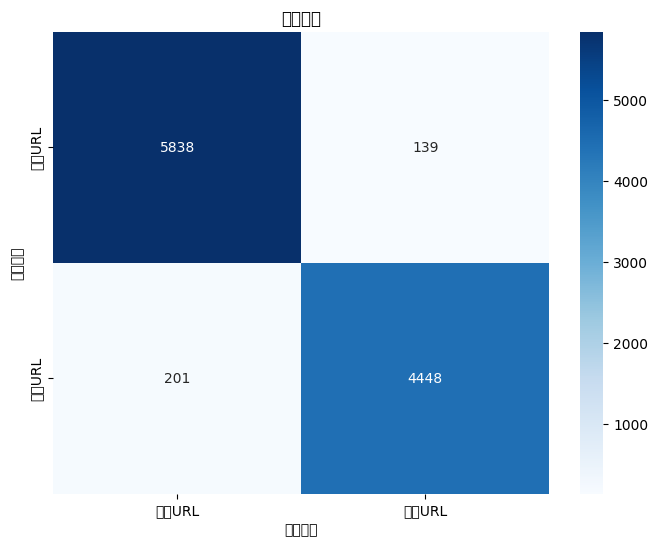

C:\Users\Hilda\AppData\Local\Temp\ipykernel_26960\1961617614.py:28: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from current font.
  plt.savefig("roc_curve.png")
C:\Users\Hilda\AppData\Local\Temp\ipykernel_26960\1961617614.py:28: UserWarning: Glyph 38451 (\N{CJK UNIFIED IDEOGRAPH-9633}) missing from current font.
  plt.savefig("roc_curve.png")
C:\Users\Hilda\AppData\Local\Temp\ipykernel_26960\1961617614.py:28: UserWarning: Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from current font.
  plt.savefig("roc_curve.png")
C:\Users\Hilda\AppData\Local\Temp\ipykernel_26960\1961617614.py:28: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  plt.savefig("roc_curve.png")
C:\Users\Hilda\AppData\Local\Temp\ipykernel_26960\1961617614.py:28: UserWarning: Glyph 26354 (\N{CJK UNIFIED IDEOGRAPH-66F2}) missing from current font.
  plt.savefig("roc_curve.png")
C:\Users\Hilda\AppData\Local\Temp\ipykernel_26960\1961617614.py:28: UserWarning:

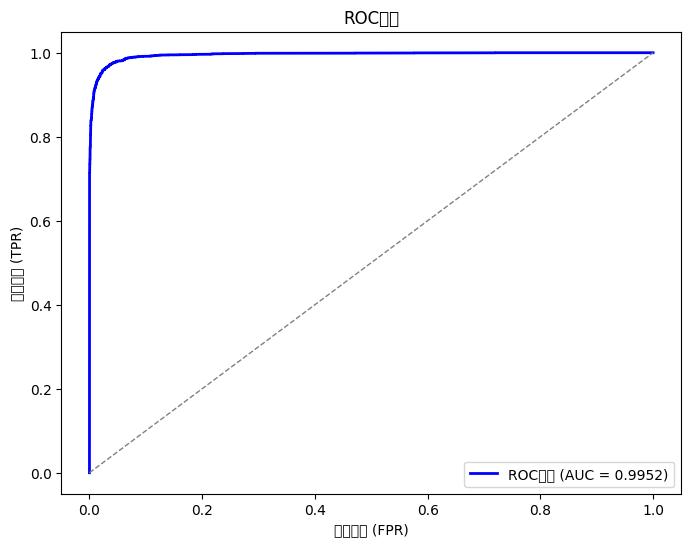

In [12]:
# 预测
y_pred_prob = model.predict([X_manual_test, X_char_test], verbose=0)
y_pred = (y_pred_prob > 0.5).astype(int)

# 输出报告
print(classification_report(y_test, y_pred, target_names=["合法URL", "钓鱼URL"]))
print(f"AUC: {roc_auc_score(y_test, y_pred_prob):.4f}")

# 混淆矩阵
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["合法URL", "钓鱼URL"], yticklabels=["合法URL", "钓鱼URL"])
plt.xlabel("预测标签")
plt.ylabel("真实标签")
plt.title("混淆矩阵")
plt.savefig("confusion_matrix.png")
plt.show()

# ROC曲线
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC曲线 (AUC = {roc_auc_score(y_test, y_pred_prob):.4f})")
plt.plot([0, 1], [0, 1], color="gray", lw=1, linestyle="--")
plt.xlabel("假阳性率 (FPR)")
plt.ylabel("真阳性率 (TPR)")
plt.title("ROC曲线")
plt.legend(loc="lower right")
plt.savefig("roc_curve.png")
plt.show()

# 九、保存模型和依赖文件

In [13]:
# 保存模型
model.save("phishing_detection_model.h5")

# 保存Tokenizer
with open("char_tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# 保存Scaler
with open("feature_scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

print("模型和依赖文件已保存！")

模型和依赖文件已保存！
